In [1]:
# Successive Convexification of Non-Convex Optimal
# Control Problems and Its Convergence Properties
# Mao, Szmuk, and Acikmese (2016)
using Gurobi, Convex
using PyPlot

In [15]:
# Simulation Parameters from Table I
Tf = 10
mass = 1.0
kd = 0.25
Tmax = 2.0
Xi = [0.;0;5;0]
Xf = [10.;10;5;0]

Δl = 0.0
ρ0 = 0.0
ρ1 = 0.25
ρ2 = 0.9
α = 2.0

2.0

In [3]:
function f{T}(X::Vector{T},U::Vector{T})
    xdot = zeros(T,n)
    V = X[3:4]
    xdot[1:2] = V
    xdot[3:4] = 1/mass*(U-kd*norm(V)*V)
    return xdot
end

function Ak{T}(X::Vector{T})
    vx,vy = X[3:4]
    out = zeros(T,n,n)
    out[1:2,1:2] = eye(T,2)
    out[3:4,3:4] = kd/mass*(vx^2+vy^2)^1.5 * [-vy^2 vx*vy;
                                            vx*vy -vx^2]
    return out
end

function Bk()
    out = zeros(n,m)
    out[3:4,:] = 1/mass*eye(m)
    return out
end

Bk (generic function with 1 method)

In [28]:
Δt = 0.25
N = Int(Tf/Δt + 1)

n,m = 4,2

Δ = 0.5; # initial trust region size for control

In [7]:
function cost{T}(Xmat::Matrix{T},Umat::Matrix{T})
    cost = T(0)
    for k in 1:size(Umat,2)
       cost += sum(abs.((Xmat[:,k+1]-Xmat[:,k])/Δt - 
                f(Xmat[:,k],Umat[:,k])))
    end
    return cost
end

cost (generic function with 1 method)

In [41]:
MAX_ITER = 10

X = Variable(n,N)
U = Variable(m,N-1)
G = Variable(N-1)

B = Bk()

# initial guess for X0 and U0
X0 = zeros(n,N)
for i in 1:n
   X0[i,:] = linspace(Xi[i],Xf[i],N) 
end
U0 = 0.5*Tmax*ones(m,N-1)

Jopt = cost(X0,U0)

Js = [Jopt]
ρs = []
soln_times = []
accepted = Bool[]

Xs,Us = [], []
push!(Xs, X0)
push!(Us, U0)

set_default_solver(GurobiSolver())
env = Gurobi.Env()
setparam!(env,"OutputFlag",0)

for iter_idx in 0:MAX_ITER
    tic()
    Jm = sum(G)
    constraints = Convex.Constraint[]

    # Boundary conditions
    constraints += X[:,1] == Xi
    constraints += X[:,end] == Xf

    for k in 1:N-1
        # lossless convexification trick
        constraints += norm(U[:,k],2) <= G[k]
        constraints += 0 <= G[k]
        constraints += G[k] <= Tmax
        
        # trust region constraints
        constraints += norm(U[:,k]-U0[:,k],2) <= Δ

#         Jm += sum(abs.(f(X0[:,k],U0[:,k]) +
#             Ak(X0[:,k])*(X[:,k]-X0[:,k]) + B*(U[:,k]-U0[:,k]) - 
#             (X[:,k+1]-X[:,k])/Δt))
        # non-linear dynamics penalty
        if k < N-1
            # trapezoidal scheme
            Jm += 0.5*sum(abs.(f(X0[:,k],U0[:,k]) + f(X0[:,k+1],U0[:,k+1]) +
                Ak(X0[:,k])*(X[:,k]-X0[:,k]) + B*(U[:,k]-U0[:,k]) +
                Ak(X0[:,k+1])*(X[:,k+1]-X0[:,k+1]) + B*(U[:,k+1]-U0[:,k+1]) -
                (X[:,k+1]-X[:,k])/Δt))
        else
            # forward Euler on last step
            Jm += sum(abs.(f(X0[:,k],U0[:,k]) +
                Ak(X0[:,k])*(X[:,k]-X0[:,k]) + B*(U[:,k]-U0[:,k]) -
                (X[:,k+1]-X[:,k])/Δt))
        end
    end

    prob = minimize(Jm,constraints)
    Convex.solve!(prob)
    
    iter_idx==0 && continue     # don't save run time results for first iteration
    
    if prob.status != :Optimal
        warn("Problem did not solve at iteration $iter_idx")
    end
    
    push!(Xs, X.value)
    push!(Us, U.value)
    
    # calculate true and modeled changes in cost
    Jnew = cost(X.value,U.value)
    Jhatnew = prob.optval - sum(G.value) # cost of NL dynamics violation
    ΔJ, ΔJhat = Jopt-Jnew, Jopt-Jhatnew
    ρ = ΔJ/ΔJhat
    
    push!(Js, Jnew)
    push!(ρs, ρ)
    
    # decide whether to accept solution
    push!(accepted, ρ>=ρ0)
    if ρ >= ρ0 && prob.status == :Optimal
        # accept this step
        X0, U0 = X.value, U.value
    end

    # update trust region size
    if ρ < ρ1
        # shrink trust region
        Δ *=  1/α
    elseif ρ >= ρ2
        # grow trust region
        Δ *=  α
    end
    
    constraints = Convex.Constraint[]
    push!(soln_times, toc())
    gc()
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 729 rows, 765 columns and 2165 nonzeros
Model has 80 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-01, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-13, 2e+01]
Presolve removed 487 rows and 402 columns
Presolve time: 0.00s
Presolved: 282 rows, 403 columns, 603 nonzeros
Presolved model has 80 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 80
 AA' NZ     : 5.200e+02
 Factor NZ  : 1.732e+03
 Factor Ops : 1.214e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.31110621e+04 -8.58249281e+01  5.56e+02 8.64e-01  3.15e+02     0s
   1   3.76913760e+03 -7.81424993e+01  8.12e+01 7.33e-06  2.72e+01   

Academic license - for non-commercial use only
Optimize a model with 729 rows, 765 columns and 2165 nonzeros
Model has 80 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-01, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-14, 2e+01]
Presolve removed 487 rows and 402 columns
Presolve time: 0.00s
Presolved: 442 rows, 403 columns, 763 nonzeros
Presolved model has 80 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 80
 AA' NZ     : 1.240e+03
 Factor NZ  : 3.493e+03
 Factor Ops : 3.219e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.31086294e+04 -8.46585713e+01  5.56e+02 8.57e-01  3.56e+02     0s
   1   3.77396984e+03 -7.45400327e+01  8.14e+01 7.23e-06  2.97e+01     0s
   2   7.85129314e+02  1.27658792e+02  1.3

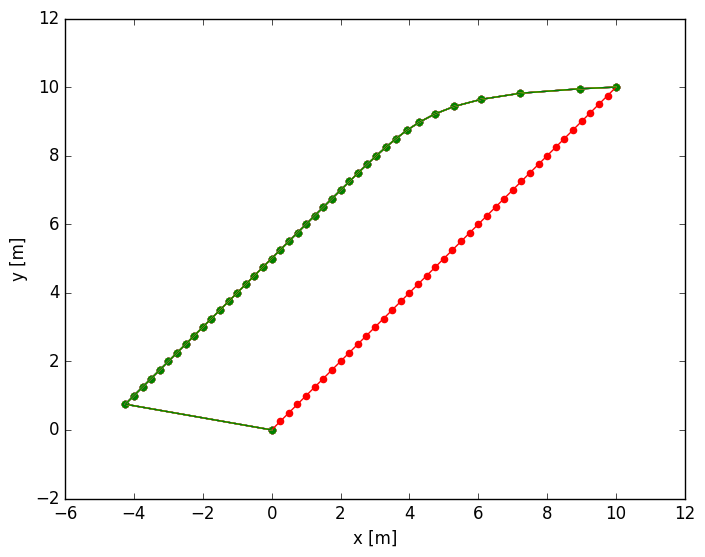

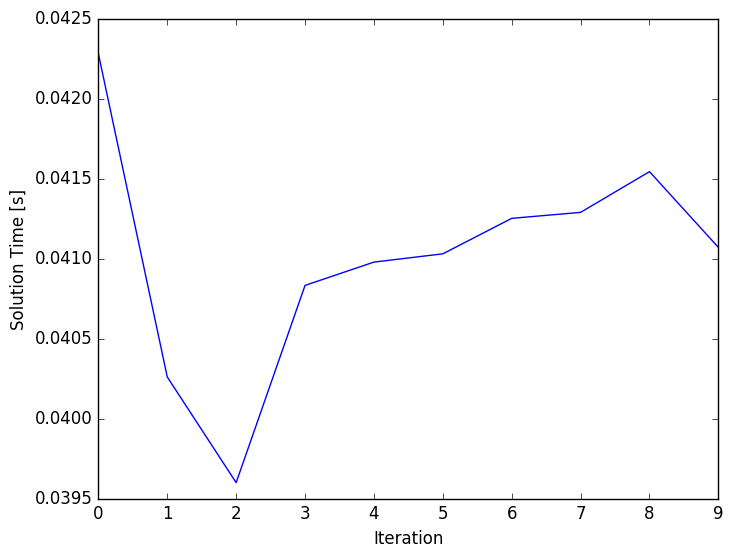

PyObject <matplotlib.text.Text object at 0x7f28daf322d0>

In [42]:
colors = ["red","yellow","green","blue","cyan","black","magenta"]
itr = 1

sf = 1
PyPlot.figure()
for (k,val) in enumerate(accepted)
    c=colors[itr]
    PyPlot.plot(Xs[k][1,:],Xs[k][2,:],color=c)
    #PyPlot.quiver(Xs[k][1,:],Xs[k][2,:],sf*Xs[k][3,:],sf*Xs[k][4,:],color=c)
    PyPlot.scatter(Xs[k][1,:],Xs[k][2,:],color=c)
    itr = (itr==length(colors)) ? 1 : itr+1
end
PyPlot.xlabel("x [m]"); PyPlot.ylabel("y [m]")

PyPlot.figure()
PyPlot.plot(soln_times)
PyPlot.xlabel("Iteration"); PyPlot.ylabel("Solution Time [s]")